# Final Project EDA

## 주제: 항생제 감수성 예측 (내성)


- Preprocess, EDA 수행


```
Introduction

응급 환자에게 있어서, 항생제 감수성 여부는 중요한 요소이다.
응급한 상황에서 항생제 1차, 2차, 3차를 투여하기에는 위험 부담이 클 뿐만아니라, 지역 항생제 감수성이 만연하게 될 것이다.
3차의 부작용이 세다.
환자의 감수성에 맞춰 1차,2차 항생제를 투여하고,  3차 항생제를 투여하지않는다면 많음 부담을 줄일 수 있을 것이다.

그래서, 환자의 감수성을 예측하는 것이 중요하다.

주요 가설은 다른 병원에 오래 있거나 고령, 침상 환자들은 지속적으로 항생제를 투여해서, 감수성이 있을것이란 것이다.

항생제중 ciprofloxacin(CIP) 내성 여부가 target이다.
CIP를 치료로 이용하는 병균 감염에는 뼈 및 관절염, 복강내 전염, 특정한 종류의 장염, 호흡기 감염, 피부 감염, 장티푸스, 요로감염증 등이 포함된다. 

```

- 과제의 목표
- 여러가지 다변량 분석 방법을 수행하고 결과들을 비교해본다.
    - PCA + MCA를 통해 수치형 범주형 변수를 나눠서 분석
    - PCA만을 이용해 분석
    - 둘간의 결과 비교
    - Factor analysis
- 다변량 분석결과를 통해 변수 변환을 거쳐서 분류 분석을 실시한다.

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import sys

import scipy.stats as stats # qqplot에 사용

In [117]:
#시각화 패키지들
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

plt.style.use("ggplot")

## 변수 설명




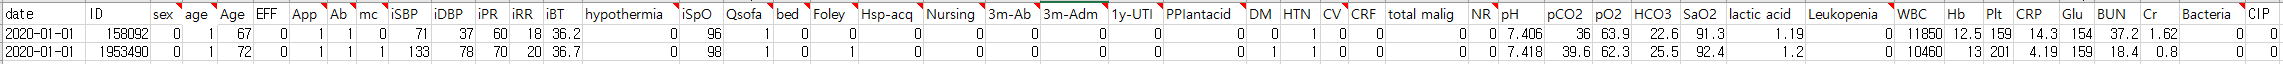

In [118]:
X = pd.read_excel("../data/CIP_data.xlsx")
print(X.shape)
X.head()

(550, 47)


,date,ID,sex,age,Age,EFF,App,Ab,mc,iSBP,...,Leukopenia,WBC,Hb,Plt,CRP,Glu,BUN,Cr,Bacteria,CIP
0,2020-01-01,158092,0,1,67,0,1.0,1.0,0,71,...,0,11850,12.5,159,14.30,154,37.2,1.62,0,0
1,2020-01-01,1953490,0,1,72,0,1.0,1.0,1,133,...,0,10460,13.0,201,4.19,159,18.4,0.80,0,0
2,2020-01-01,1953526,0,1,74,0,1.0,1.0,0,172,...,0,8430,12.7,183,9.24,269,13.0,0.70,0,0
3,2020-01-01,1260373,1,1,78,0,1.0,2.0,0,166,...,0,5740,11.9,152,4.59,138,29.5,1.73,0,1
4,2020-01-02,1842207,0,0,48,0,1.0,1.0,0,122,...,0,10530,12.3,207,0.18,109,11.5,0.97,0,0


In [119]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 47 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         550 non-null    object 
 1   ID           550 non-null    int64  
 2   sex          550 non-null    int64  
 3   age          550 non-null    int64  
 4   Age          550 non-null    int64  
 5   EFF          550 non-null    int64  
 6   App          361 non-null    float64
 7   Ab           546 non-null    float64
 8   mc           550 non-null    int64  
 9   iSBP         550 non-null    int64  
 10  iDBP         550 non-null    int64  
 11  iPR          550 non-null    int64  
 12  iRR          550 non-null    int64  
 13  iBT          550 non-null    float64
 14  hypothermia  550 non-null    int64  
 15  iSpO         530 non-null    float64
 16  Qsofa        550 non-null    int64  
 17  bed          550 non-null    int64  
 18  Foley        550 non-null    int64  
 19  Hsp-acq 

```
(date형) date : 검사 날짜. (제거)
(수치) id: (제거)
(범주형) sex : 성별 [0:여,1:남 ]
(범주형,변수가공) age : 65세 [전:0 후:1] (분포를 보고 다시 결정)
(수치형) Age : 나이 
(범주형) EFF : Effectiveness. 감수성 여부를 떠나서 효과가 있었던 사람. (삭제해도되는 것.)
(범주형) App : 응급실에서 적절한 항생제를 사용했는지 여부. (제거 예정. 차후 결과 비교에 사용) (Ab 이용)
(범주형) Ab :  응급실에서 어떤 항생제를 투여했는지 여부, (0:CIP ,1:CTX ,2:PT ,3:Maxipime , 4 :no) (제거 예정)
(범주형) mc :  환자 의식이 변화된 정도. mental change. (없으면0 생기면 1) (제거해야할까. qSofa에 사용.)
(수치형) iSBP : 침습적 혈압 측정. invasive blood pressure 
(수치형) iDBP : 침습적 이완기 혈압 측정. invasive Diastolic  blood pressure
(수치형) iRR :  침습적 호흡 측정. Respiratory rate
(수치형) iBT :  침습적 체온 측정. invasive Body Temperature
(범주형,변수가공) hypothermia : 36도 미만 저체온 여부 (분포 보고 다시 결정.)
(수치형) iSpO :  산소포화도. Peripheral oxygen saturation
(범주형,label encoding) Qsofa : 의식 변화, 수축기 혈압, 호흡수를 기준으로 점수를 내 사망률 위험 추정 점수 . Quick Sequential Organ Failure Assessment 
(범주형) **bed : 침상환자 여부
(범주형) Foley : 도뇨관의 종류. (Urinary catheter/Cystostomy)
(범주형) **Hsp-acq : 최근 수술 및 입원 여부  hospital acquired (1. 2일 이상 입원후 전원 2. 30일내 수술력 3. 퇴원한지 3일내)
(범주형) Nursing : 요양원,가정 간호 여부
(범주형) 3m-Ab : 3달 이내 항생제 복용여부 
(범주형) 3m-Adm : 최근 3달내 입원 여부
(범주형) **1y-UTI : 1년내 요로감염이력
(범주형) PPlantacid : 위식도 역류질환 제산제 사용여부
(범주형) CV : 혈압 제외 심장질환 여부 (CAOD, HCMP, CHF)
(범주형) CRF  : 만성신부전 여부 Chronic Renal Failure
(범주형) total malig :  악성 종양 여부
(범주형) NR : neurodegenerative disease 여부 :CVA, Dementia,CP 포함.
(범주형) Leukopenia : 백혈구 감소증 여부. WBC<4000 (domain내용으로 사용예정.)
(수치형) Hb	Hemoglobin 헤모글로빈
(수치형) Plt	Pulse rate 맥박수
(수치형) CRP	C 반응성 단백질 (페렴 구균에 반응)
(수치형) Glu	Glucose 글루테인
(수치형) BUN	Blood urea nitrogen 혈액 요소성 질소.
(수치형) Cr	Creatinine
(범주형) Bacteria : 박테리아 감염 여부. 어떤 박테리아냐에 따라 (ground-truth와 같이 나오는 자료이기에 사용할 수 없다.)

-- target
(범주형 TARGET) CIP : CIP 내성 여부. (소변검사 실시. ground truth)


** 은 알려진 주요 변수를 의미한다.

```

- PCA + MCA를 통해 수치형 범주형 변수를 나눠서 분석
- PCA만을 이용해 분석
- Factor analysis
- 둘간의 결과 비교



https://syj9700.tistory.com/44

https://dschloe.github.io/python/python_edu/05_statistics/chapter_5_2_positioning_analysis_2/

CA를 통해 범주들 간에 관계를 살펴볼 수도 있다.


In [120]:
X[['sex','age','EFF','App','Ab','mc','hypothermia','Qsofa','bed','Foley',
   'Hsp-acq','Nursing','3m-Ab','3m-Adm','1y-UTI','PPIantacid',
   'CV','CRF','total malig','NR','Leukopenia','Bacteria']] =X[['sex','age','EFF','App','Ab','mc','hypothermia','Qsofa','bed','Foley',
   'Hsp-acq','Nursing','3m-Ab','3m-Adm','1y-UTI','PPIantacid',
   'CV','CRF','total malig','NR','Leukopenia','Bacteria']].astype('category') 

In [121]:
X.describe()

,ID,Age,iSBP,iDBP,iPR,iRR,iBT,iSpO,DM,HTN,...,SaO2,lactic acid,WBC,Hb,Plt,CRP,Glu,BUN,Cr,CIP
count,5.500000e+02,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,530.000000,550.000000,550.000000,...,521.000000,516.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000
mean,1.135138e+06,72.130909,127.550909,72.983636,97.938182,20.254545,38.547273,95.632075,0.420000,0.589091,...,96.192898,2.652539,12006.927273,11.784727,209.623636,12.125800,165.023636,28.350727,1.347418,0.465455
std,7.118698e+05,15.857320,30.484792,17.838011,22.045734,3.807854,14.990417,4.687847,0.494008,0.492447,...,38.449239,6.337611,6495.844084,8.963564,100.975272,8.980668,94.303763,44.084563,1.319023,0.499259
min,6.110000e+02,18.000000,46.000000,32.000000,32.000000,12.000000,25.600000,36.000000,0.000000,0.000000,...,31.100000,0.200000,360.000000,5.400000,10.000000,0.040000,28.000000,4.500000,0.320000,0.000000
25%,4.367282e+05,65.000000,106.000000,60.000000,84.000000,18.000000,37.000000,95.000000,0.000000,0.000000,...,93.200000,1.140000,7805.000000,10.100000,144.250000,5.422500,111.000000,13.100000,0.720000,0.000000
50%,1.197335e+06,76.000000,126.500000,72.000000,98.000000,20.000000,38.000000,97.000000,0.000000,1.000000,...,95.500000,1.660000,11150.000000,11.500000,193.500000,10.465000,139.000000,20.600000,0.970000,0.000000
75%,1.910642e+06,83.000000,150.000000,83.000000,113.000000,22.000000,38.900000,98.000000,1.000000,1.000000,...,97.200000,2.740000,14807.500000,12.700000,254.750000,16.880000,183.750000,33.375000,1.520000,1.000000
max,2.015722e+06,102.000000,208.000000,138.000000,182.000000,50.000000,388.000000,100.000000,1.000000,1.000000,...,964.000000,100.000000,54280.000000,216.000000,831.000000,52.610000,951.000000,939.400000,20.300000,1.000000


## 데이터 제거

- [date , id ,Age , EEF, App, Ab , hypothermia ] 컬럼 제거

In [122]:
X.drop(['date','ID','age','EFF','App','Ab','hypothermia'],axis=1,inplace=True)

# 데이터 확인

In [123]:
X

,sex,Age,mc,iSBP,iDBP,iPR,iRR,iBT,iSpO,Qsofa,...,Leukopenia,WBC,Hb,Plt,CRP,Glu,BUN,Cr,Bacteria,CIP
0,0,67,0,71,37,60,18,36.2,96.0,1,...,0,11850,12.5,159,14.30,154,37.2,1.62,0,0
1,0,72,1,133,78,70,20,36.7,98.0,1,...,0,10460,13.0,201,4.19,159,18.4,0.80,0,0
2,0,74,0,172,71,117,24,39.5,95.0,1,...,0,8430,12.7,183,9.24,269,13.0,0.70,0,0
3,1,78,0,166,78,93,28,38.8,85.0,1,...,0,5740,11.9,152,4.59,138,29.5,1.73,0,1
4,0,48,0,122,81,83,16,36.7,98.0,0,...,0,10530,12.3,207,0.18,109,11.5,0.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,0,74,0,135,76,93,18,37.3,100.0,0,...,0,20770,11.9,276,20.72,157,11.4,0.55,0,0
546,1,83,0,167,85,89,32,39.2,95.0,1,...,0,7850,11.1,84,4.40,112,16.5,1.51,0,1
547,0,77,0,81,49,117,20,38.3,95.0,1,...,0,10600,10.0,296,7.74,141,21.2,0.72,0,1
548,0,86,0,177,79,69,20,37.5,99.0,0,...,0,6560,7.3,209,0.84,115,34.0,2.68,0,1


In [124]:
#차원 확인
print("all data: ",X.shape)

all data:  (550, 40)


In [125]:
print("yes : ",sum(X['CIP']==1))
print("no : ",sum(X['CIP']==0))

yes :  256
no :  294


Label이 균형있게 분포되어있다.

## 데이터 분할

In [126]:
Y=X['CIP']
X.drop(['CIP'],axis=1,inplace=True)

In [127]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=42)

In [128]:

print('train set : ',x_train.shape)
print('test set : ', x_test.shape)

train set :  (440, 39)
test set :  (110, 39)


## 결측치 확인

In [129]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        col_type = dataframe[col].dtype
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: ({col_type}) {col} 입니다. 해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(x_train)

결측치가 있는 컬럼은: (float64) iSpO 입니다. 해당 컬럼에 총 16 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (category) 3m-Ab 입니다. 해당 컬럼에 총 5 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (category) 3m-Adm 입니다. 해당 컬럼에 총 5 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (category) 1y-UTI 입니다. 해당 컬럼에 총 5 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (category) PPIantacid 입니다. 해당 컬럼에 총 5 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (category) CV 입니다. 해당 컬럼에 총 1 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (float64) pH 입니다. 해당 컬럼에 총 61 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (float64) pCO2 입니다. 해당 컬럼에 총 61 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (float64) pO2 입니다. 해당 컬럼에 총 61 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (float64) HCO3 입니다. 해당 컬럼에 총 61 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (float64) SaO2 입니다. 해당 컬럼에 총 24 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: (float64) lactic acid 입니다. 해당 컬럼에 총 27 개의 결측치가 존재합니다.


- 결측치 처리 방법.

많은 결측치가 수치형 자료에 존재한다. 수치형 자료의 결측치 수가 10% 이상이기에, 모두 제거할 수는 없다고 생각된다.

범주형 자료들은 예측할 수 없기에, 모두 제거한다.


In [130]:
x_train=x_train[x_train[['3m-Ab','3m-Adm','1y-UTI','PPIantacid','CV']].isna().sum(axis=1)==0]
print(x_train.shape)

(434, 39)


- 수치형 변수 결측치 처리방법.

수치형 자료들은, 상관 계수를 보고 높은 컬럼들을 선정해서 회귀식을 세운다.

In [164]:
not_in=list(set(x_train.corr().columns) - set(['iSpO','pH','pCO2','pO2','HCO3','SaO2','lactic acid']))
x_train.corr().loc[['iSpO','pH','pCO2','pO2','HCO3','SaO2','lactic acid'],not_in]

,iSBP,CRP,iPR,iRR,Hb,Plt,Glu,DM,WBC,BUN,Age,iBT,iDBP,Cr,HTN
iSpO,0.120557,-0.012977,0.062504,-0.297137,0.035246,-0.088129,-0.079058,-0.083537,-0.047372,-0.118041,-0.186453,0.038919,0.037098,-0.083460,-0.081356
pH,-0.018907,-0.049728,0.039288,-0.004782,0.002075,-0.046348,-0.001470,-0.048298,-0.037841,-0.019188,-0.030215,-0.003742,0.014711,-0.005702,-0.065444
pCO2,0.077855,-0.132551,-0.113828,-0.027117,0.041846,0.020022,0.045533,-0.043625,-0.085605,-0.163118,0.055737,-0.054167,0.085971,-0.228553,0.030006
pO2,-0.028199,-0.011351,-0.041603,0.034121,-0.097057,0.071493,-0.075067,-0.032763,0.031243,0.131399,-0.031192,-0.009438,-0.013694,0.050688,-0.088532
HCO3,0.061479,-0.057698,-0.083544,-0.036026,0.069062,0.045971,-0.030330,0.001409,-0.059883,-0.262468,0.039586,-0.008539,0.144542,-0.324227,0.027918
SaO2,0.037232,-0.039595,0.066825,-0.041217,-0.020404,-0.019937,0.028420,0.041364,-0.014283,-0.048569,-0.157035,0.001625,0.016487,-0.038578,-0.074490
lactic acid,-0.030598,-0.030332,0.048043,0.033142,0.126449,-0.030625,0.025981,-0.036578,0.000353,-0.016359,-0.062709,-0.012898,0.009979,-0.008772,-0.032486


In [143]:
x_train[x_train[['pH','pCO2','pO2','HCO3']].isna().sum(axis=1)>0]

,sex,Age,mc,iSBP,iDBP,iPR,iRR,iBT,iSpO,Qsofa,...,lactic acid,Leukopenia,WBC,Hb,Plt,CRP,Glu,BUN,Cr,Bacteria
114,1,60,0,128,75,88,20,38.3,99.0,0,...,NaN,0,7570,14.6,206,18.39,140,17.5,0.68,0
76,0,24,0,99,51,89,18,37.1,NaN,1,...,NaN,0,14760,12.7,243,2.93,82,8.7,0.68,0
188,1,78,0,93,54,105,18,38.0,98.0,1,...,NaN,0,17460,12.5,153,17.19,191,26.7,1.68,0
349,0,64,0,138,52,106,18,39.1,96.0,0,...,2.94,0,8480,12.2,225,1.88,110,10.5,0.70,0
361,1,52,0,118,67,92,18,38.4,NaN,0,...,NaN,0,7420,14.6,174,8.16,109,10.5,0.62,0
486,0,37,0,114,70,122,20,38.9,100.0,0,...,NaN,0,10900,12.9,213,7.67,115,15.1,0.76,0
466,0,27,0,95,72,123,20,37.3,98.0,1,...,1.41,0,15540,11.7,151,20.43,89,6.2,0.58,0
363,0,77,0,129,79,117,20,39.4,93.0,0,...,1.08,1,3310,12.0,173,9.27,186,31.8,1.17,0
320,0,54,0,109,68,90,20,39.1,NaN,0,...,NaN,0,6520,13.5,237,6.16,127,17.5,0.94,0
155,0,51,0,119,81,108,18,39.2,99.0,0,...,NaN,0,8910,12.3,209,5.91,104,14.5,0.62,0


In [35]:
X[X[['pH','pCO2','pO2','HCO3']].isna().sum(axis=1)==0]
missing_col = check_missing_col(X[X[['pH','pCO2','pO2','HCO3']].isna().sum(axis=1)==0])

결측치가 있는 컬럼은: 3m-Ab 입니다. 해당 컬럼에 총 6 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: 3m-Adm 입니다. 해당 컬럼에 총 5 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: 1y-UTI 입니다. 해당 컬럼에 총 6 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: PPIantacid 입니다. 해당 컬럼에 총 6 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: CV 입니다. 해당 컬럼에 총 1 개의 결측치가 존재합니다.
결측치가 있는 컬럼은: lactic acid 입니다. 해당 컬럼에 총 2 개의 결측치가 존재합니다.


In [36]:
X.columns

Index(['sex', 'age', 'mc', 'iSBP', 'iDBP', 'iPR', 'iRR', 'iBT', 'iSpO',
       'Qsofa', 'bed', 'Foley', 'Hsp-acq', 'Nursing', '3m-Ab', '3m-Adm',
       '1y-UTI', 'PPIantacid', 'DM', 'HTN', 'CV', 'CRF', 'total malig', 'NR',
       'pH', 'pCO2', 'pO2', 'HCO3', 'SaO2', 'lactic acid', 'Leukopenia', 'WBC',
       'Hb', 'Plt', 'CRP', 'Glu', 'BUN', 'Cr', 'Bacteria', 'CIP'],
      dtype='object')

# 테스트셋 보정